In [1]:
import os, sys
import scipy
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import sklearn 
from sklearn.ensemble import GradientBoostingRegressor
import sklearn.metrics
import sklearn.model_selection
import sklearn.preprocessing
import sklearn.feature_extraction

%matplotlib inline


/usr/local/lib/python3.10/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
final_gdf = pickle.load(open("./data_out/source_of_truth.pkl","rb"))
final_gdf_cut = final_gdf[~final_gdf.food_sec_index.apply(lambda x: np.any([v is None for v in x]))].copy()
final_gdf_excl = final_gdf[final_gdf.food_sec_index.apply(lambda x: np.any([v is None for v in x]))].copy()


In [3]:
T_mem = 5
model = pickle.load(open("models/imputation_model_T_mem_{}.pkl".format(T_mem),"rb"))

In [9]:

new_food_sec_index_ts = []
for country in final_gdf_excl.name.values:
    df_aux = final_gdf_excl.loc[country]
    country_index_ts = np.array(df_aux["country_index"])
    rainfall_mm_ts = np.array(df_aux["rainfall_mm"])
    conflict_index_ts = np.array(df_aux["conflict_index"])
    food_sec_index_ts = df_aux["food_sec_index"]
    T = len(country_index_ts)


    for t in range(T_mem, T):

        X = np.concatenate([
            country_index_ts[np.newaxis,t-T_mem:t+1],
            rainfall_mm_ts[np.newaxis,t-T_mem:t+1],
            conflict_index_ts[np.newaxis,t-T_mem:t+1],
        ], axis=1)

        y = model.predict(X)
        if y<0: y=0
        food_sec_index_ts[t] = float(y)

    new_food_sec_index_ts.append(food_sec_index_ts)
new_food_sec_index_ts = np.array(new_food_sec_index_ts)
final_gdf_excl["food_sec_index"] = [v for v in new_food_sec_index_ts]

# Ts single country

In [10]:
def large_variation_flag(ts, threshold=0.5, tresh_time=600, to_bottom=True):
    final_avg = np.mean(ts[tresh_time:])
    if to_bottom and final_avg<threshold:
        return 1
    elif (not to_bottom) and final_avg>threshold:
        return 1
    else:
        return 0
    
final_gdf_excl["food_index_low"] = final_gdf_excl.food_sec_index.apply(lambda ts:large_variation_flag(ts,threshold=0.01))
final_gdf_excl["econ_collapse"] = final_gdf_excl.country_index.apply(lambda ts:large_variation_flag(ts,threshold=50))
final_gdf_excl["rainfall_down"] = final_gdf_excl.rainfall_mm.apply(lambda ts:large_variation_flag(ts,threshold=50))
final_gdf_excl["conflict_on"] = final_gdf_excl.conflict_index.apply(lambda ts:large_variation_flag(ts,threshold=0.4,to_bottom=False))


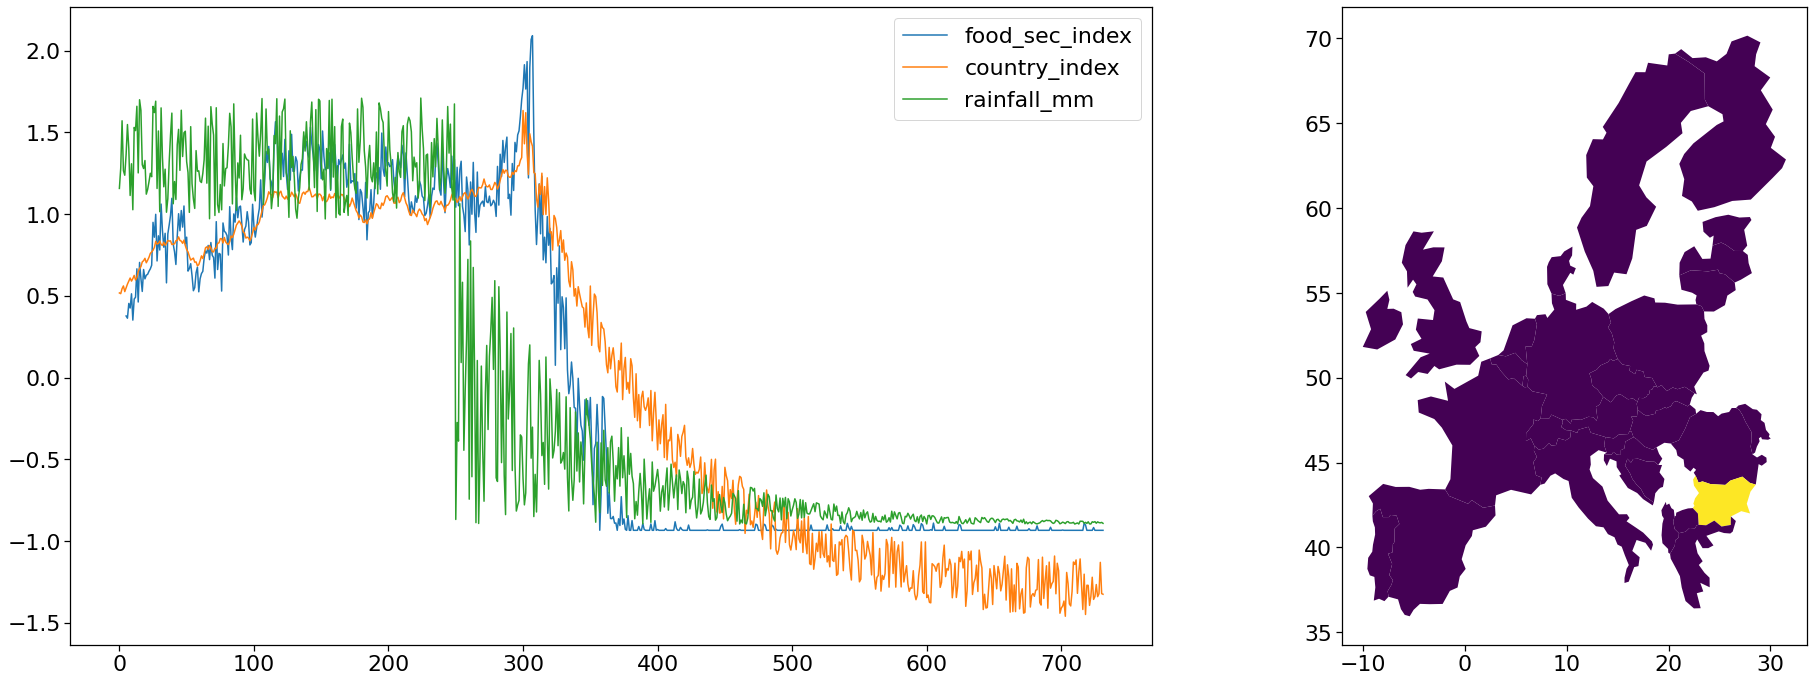

<Figure size 432x288 with 0 Axes>

In [11]:
from sklearn.preprocessing import StandardScaler
final_gdf_food_index_low = final_gdf_excl[final_gdf_excl.food_index_low==1].copy()


indices = ["food_sec_index","country_index","rainfall_mm","conflict_index"]
indices_flags = ["food_index_low","econ_collapse","rainfall_down","conflict_on"]


for country in final_gdf_food_index_low.name.values:

    sns.set_context("notebook", font_scale=2)
    fig, axs = plt.subplots(figsize=(30,10), ncols=2, nrows=1)

    ##################
    ax = axs[0]
    df_aux = final_gdf_food_index_low.loc[country]
    for index,flag in zip(indices,indices_flags):
        if df_aux[flag]==0: continue
        
        if index != "food_sec_index":
            ts = np.array(df_aux[index])[:, np.newaxis]
            ts = StandardScaler().fit_transform(ts)
        else:
            ts = np.array(df_aux[index])[:, np.newaxis]
            ts_mem = StandardScaler().fit_transform(ts[T_mem:])
            ts[T_mem:] = ts_mem
        ax.plot(ts, label=index)
    ax.legend()

    ##################

    ax = axs[1]
    final_gdf_aux = final_gdf.copy()
    final_gdf_aux["our_country"] = False
    final_gdf_aux.loc[final_gdf_aux.name==country,"our_country"]=True
    final_gdf_aux.plot("our_country",ax=ax)

    plt.tight_layout()
    plt.show()
    plt.savefig("figures/ts_single_country_{}_imputed.png".format(country), dpi=300)